In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
run="run_al"

In [2]:
sc = xr.open_dataset("/home/disk/eos15/smturbev/DPSCREAM_simulations/dpscream_small_3km/{}/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run,run[-2:]))
# sc = sc.isel(time=slice(-10,-1))
sce = sc.isel(time=slice(-10,-1)).mean(dim=["time"])# last time step # last ten days: (time=slice(-10,-1)).mean(dim=["time"]) 
sci = sc.isel(time=0) # first time step

print(sc["T"].shape, sce["T"].shape, sci["T"].shape)

(43, 128, 1296) (128, 1296) (128, 1296)


# temp and wv initial conditions

plot in day day averages to see evolution/convergence to equilibrium 

if save_new_eq = True then we save the last ten day mean to a new file

1 10
11 20
21 30
31 40


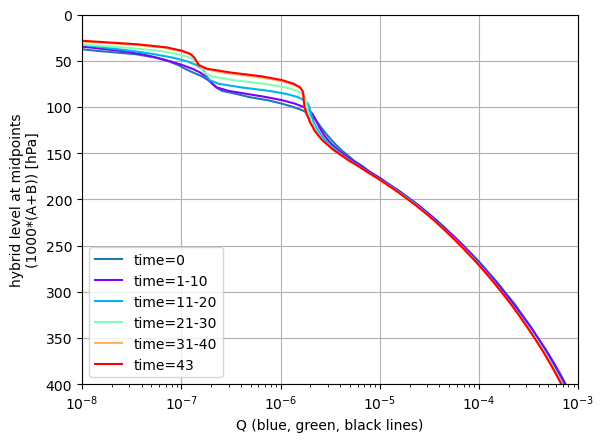

saved as plots/run_al_10daymeans_Q.png


In [6]:
# plot temperature/wv (T,T/Q,q) profiles
vsc="Q"
fig, ax = plt.subplots(1,1)
sci_mean = sci[vsc].mean(dim=["ncol"])
sce_mean = sce[vsc].mean(dim=["ncol"])
sci_mean.plot(y="lev", label="time=0", ax=ax, color="C0")
cmap=mcm.get_cmap('rainbow')

for i in range(len(sc.time)//10):
    # plot 10 days averages from start to end
    print(1+(10*i),10+(10*i))
    sc_plot10days = sc[vsc].isel(time=slice(1+(10*i),10+(10*i))).mean(dim=["time","ncol"])
    ci = cmap(i/(len(sc.time)//10))
    sc_plot10days.plot(y="lev", label="time={}-{}".format(1+(10*i),10+(10*i)), 
                       ax=ax, color=ci)
sce_mean.plot(y="lev", label="time={}".format(len(sc.time)), ax=ax, color="red")
# axis stuff
ax.legend(loc="lower left")
ax.set_xlabel(vsc+" (blue, green, black lines)")
ax.set_ylim([400,0])
ax.grid(True)
if vsc=="T":
    ax.set_xlim([172,260]) # for temp
else:
    ax.set_xlim([1e-8,1e-3]) # for wv
    ax.set_xscale("log")     # for wv

#save and show plot
save_name="plots/{}_10daymeans_{}.png".format(run, vsc)
# plt.savefig(save_name)
plt.show()
print("saved as",save_name)

In [7]:
# # save last 10 day mean temp profile to new iop file
save_new_eq=False

if save_new_eq:
    var="Tq"
    var_new="q"
    if (var=="Q") or (var=="T"):
        new_temp = sce[var].interp(lev=iop.lev.values/100, 
                                   method="linear").mean(dim="ncol").values.astype("float32")
        print(new_temp.shape, type(new_temp))
        # make new dataarray with dim from iop file
        print(iop[var_new].dims, iop[var_new].coords, iop[var_new].attrs)
        da = xr.DataArray(np.repeat(new_temp[np.newaxis,:,np.newaxis,np.newaxis], 2, axis=0), 
                          dims=iop[var_new].dims, 
                          coords=iop[var_new].coords, 
                          attrs=iop[var_new].attrs)
        iop_new = iop.assign({var_new:da})
        print(iop_new)
        
        # check it looks right
        plt.plot(new_temp, iop_new.lev.values/100, label="interp lev", marker=".")
        plt.plot(iop[var_new][0,:,0,0], iop_new.lev.values/100, label="iop0")
        plt.plot(iop[var_new][1,:,0,0], iop_new.lev.values/100, label="iop1", linestyle="dashed")
        sce[var].mean(dim="ncol").plot(y="lev", label="full "+var, linestyle="dotted")
        plt.ylim([1000,0])
        plt.legend()
        plt.show()

        # check no nans or inf
        iop_new[var_new][:,:8,0,0]=iop[var_new][:,:8,0,0].values
        print(iop_new[var_new][0,:12,0,0].values)
        print("Nan and inf count:",
              np.sum(np.isnan(iop_new[var_new].values)), 
              np.sum(np.isinf(iop_new[var_new].values)))

        # save iop with new temp profile
        iop_new.to_netcdf("../run_scripts/Cheyenne/RCE_iopfile_4scam_new{}.nc".format(var_new))
        print("saved {}".format(var_new))
    else:
        ## save both T and q new profiles
        iop_t = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_newT.nc")
        iop_newq = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_newq.nc")
        iop_newTq = iop_newq.assign({"T":iop_t.T})

        # check its different
        iop_t.T[0,:,0,0].plot(y="lev", label="iopt")
        iop_newq.T[0,:,0,0].plot(y="lev", label="iopt old")
        iop_newTq.T[0,:,0,0].plot(y="lev", linestyle="dotted", 
                                  linewidth=2, label="iopt new", color='r') 
        plt.ylim([100000,0])
        plt.legend()
        plt.show()

        iop_t.q[0,:,0,0].plot(y="lev", label="iop og")
        iop_newq.q[0,:,0,0].plot(y="lev", label="iopq new")
        iop_newTq.q[0,:,0,0].plot(y="lev", linestyle="dotted", 
                                  linewidth=2, label="ioptq new", color='r') 
        plt.ylim([100000,0])
    #     plt.xscale("log")
        plt.legend()
        plt.show()

        # save iop with new temp and q profiles
        iop_newTq.to_netcdf("../run_scripts/Cheyenne/RCE_iopfile_4scam_new{}.nc".format(var))
        print("saved ",var)

# plot RH_ice

Calculate RH wrt ice then plot in 10 day averages like above

In [8]:
plot_rh=True
# def function to calculate RHice from xarray
def rh_ice(ds, varQ="Q", varT="T", z_units="hPa"):
    """ input: xarray with variables Q and T
        output: xarray of rh wrt ice
    """
    e_si = np.exp(9.550426 - 5723.265/ds[varT] \
                  + 3.53068*np.log(ds[varT]) - 0.00728332*ds[varT])
    if z_units=="hPa":
        z = ds.lev*100
    else:
        z=ds.lev
    w_si = (0.622 * e_si) / (z - e_si)
    w_i  = ds[varQ] / (1 - ds[varQ])
    rh_ice = w_i/w_si * 100
    return rh_ice

(43, 128, 1296)
1 10
11 20
21 30
31 40


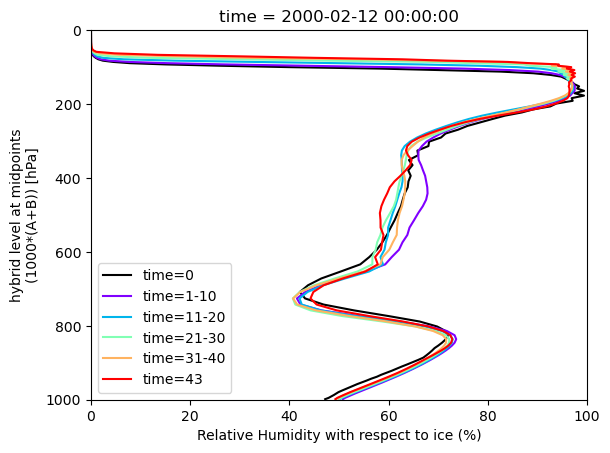

In [13]:
if plot_rh:
    rh_run = rh_ice(sc)
    print(rh_run.shape)

    fig, ax = plt.subplots(1,1)

    # plot initial timestep
    rh_run.isel(time=0).mean(
        dim=["ncol"]).plot(
        y="lev", label="time=0", ax=ax, color="k")

    cmap=mcm.get_cmap('rainbow')
    for i in range(len(sc.time)//10):
        # plot 10 days averages from start to end
        print(1+(10*i),10+(10*i))
        sc_plot10days = rh_run.isel(time=slice(1+(10*i),10+(10*i))).mean(dim=["time","ncol"])
        ci = cmap(i/(len(sc.time)//10))
        sc_plot10days.plot(y="lev", label="time={}-{}".format(1+(10*i),10+(10*i)), 
                           ax=ax, color=ci)
    # plot end time
    rh_run.isel(time=-1).mean(
        dim=["ncol"]).plot(
        y="lev", label="time={}".format(len(rh_run.time)), ax=ax, color="red")
    # axis stuff
    ax.legend(loc="lower left")
    ax.set_xlabel("Relative Humidity with respect to ice (%)")
    ax.set_ylim([1000,0])
    ax.set_xlim([0,100]) # for wv

    #save and show plot
    save_name="plots/{}_initial_condition_iop_comp_rhice.png".format(run)
    plt.savefig(save_name)
    plt.show()

In [15]:
# confirm new saved iop files
# plot temperature/wv (T/Q) profiles
vsc=None # options, T, Q, None
if vsc is not None:
    fig, ax = plt.subplots(1,1)
    og = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam.nc")[vsc]
    nt = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_newT.nc")[vsc]
    nq = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_newq.nc")[vsc]
    tq = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_newTq.nc")[vsc]
    nw = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_smooth-mean-ascent.nc")[vsc]

    og_mean = og.isel(time=0).isel(lon=0).isel(lat=0)
    nt_mean = nt.isel(time=0).isel(lon=0).isel(lat=0)
    nq_mean = nq.isel(time=0).isel(lon=0).isel(lat=0)
    tq_mean = tq.isel(time=0).isel(lon=0).isel(lat=0)
    #time=0xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_newTq.nc")[vsc]
    nt_mean.plot(y="lev", label="new T", ax=ax, linewidth=2)
    nq_mean.plot(y="lev", label="new q", ax=ax)
    tq_mean.plot(y="lev", label="new T and q", ax=ax, linestyle="dashed")
    og_mean.plot(y="lev", label="og iop", ax=ax, color="k", linestyle="dotted")


    # axis stuff
    ax.legend(loc="lower left")
    ax.set_xlabel(vsc)
    ax.set_ylim([40000,0])
    if vsc=="T":
        ax.set_xlim([172,260]) # for temp
    else:
        ax.set_xlim([1e-8,1e-3]) # for wv
        ax.set_xscale("log")     # for wv

    #save and show plot
    save_name="plots/initial_condition_iop_comp_{}.png".format(vsc)
    # plt.savefig(save_name)
    plt.show()
    print("saved as",save_name)

# vertical velocity


In [23]:
def calc_rho(ds):
    Tv = (1 + 0.61*ds.q)*ds.T
    rho = ds.lev / (287*Tv)
    return rho

def omega0(p):
    """ for p from 0-100 hPa:   omega = omega_100/100*p
        for p from 100-1000 hPa:omega = -omega_100/900 + omega_100*10/9
        omega_100 =~ 0.006 Pa/s or 6e-5 hPa/s
        pressure in hPa
        returns omega in Pa/s
    """
    omega100=-6e-6
    omega0_70 = np.where(p<50, omega100/100*p, 0)
    omega70_100 = np.where((p>=50)&(p<100), omega100, 0)
    omega100_1000 = np.where(p>=100, -omega100/900*p +omega100*10/9, 0)
    omega = omega0_70+omega70_100+omega100_1000
    return omega*100 #Pa/s

In [17]:
# vertical velocity initial condition
# add large scale ascent 3 mm/s from 100 hPa 
# gradually decreasing until 250 hPa when w=0

# plot current w initial
# iop.omega[0,:,0,0].plot(y="lev", label="og")
# 3 mm/s to omega (Pa/s)
# omega = rho / g * w
# rho = calc_rho(iop.isel(time=0).isel(lon=0).isel(lat=0))
# g = 9.8
# omega = -rho * g * 0.0003 # (kg/m/s2)/s = Pa/s
# print(omega.shape)
# omega.plot(y="lev", label="3mm/s everywhere")
# constrain omega to be nonzero between 100 and 250 hPa
# omega = omega.where((omega.lev<25000)&(omega.lev>=10000), other=0)
# omega.plot(y="lev", label="3mm/s (100-250hPa)")
# # degrade to zero after 100 hPa
# omega3 = omega.sel(lev=11000, method="nearest").values
# print(omega3)
# omega = xr.where((omega.lev<25000)&(omega.lev>=10000), omega3, 0)
# omega.plot(y="lev", label="$\omega_3$ (100-250 hPa)")
# plt.ylim([100000,0])
# plt.legend()
# plt.savefig("plots/initial_conditions_omega_0.3mms-1.png")
# plt.show()


In [18]:
# save omega3 to iop file
# omega_save = omega.expand_dims({"time":2, "lat":1, "lon":1}, axis=(0,2,3)).astype("float32")
# print(omega_save.shape)
# iop_tq = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_newTq.nc")
# iop_tqw = iop_tq.assign({"omega":omega_save})
# iop_tqw.omega.attrs["units"] = "Pa/s"
# iop_tqw.omega.attrs["long_name"] = "vertical velocity in pressure coordinates"
# print(iop_tqw.omega.min().values, iop_tqw.omega.max().values)
# iop_tqw.to_netcdf("../run_scripts/Cheyenne/RCE_iopfile_4scam_newTqw.nc")
# print("done")

In [19]:
# ds = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_smooth-mean-ascent.nc")
# ds.omega.isel(time=0).isel(lat=0).isel(lon=0).plot(y="lev")
# plt.ylim([100000,0])
# plt.show()

In [20]:
# y = ds.lev.values
# omega = omega0(y/100)

In [21]:
# fit = np.poly1d(np.polyfit(y, omega, 8))
# fig = plt.figure(figsize=(3,4))
# # plt.plot(omega, y)
# plt.plot(fit(y), y/100)
# plt.xlabel("$\omega$ in iop file (Pa/s)")
# # plt.yscale('log')
# plt.ylim([120,30])
# plt.show()

In [13]:
# omega_fit = xr.DataArray(np.array(fit(y)), dims=["lev"], coords={"lev":ds.lev}, 
#                          attrs={"long_name":"mean omega profile (continuous)", 
#                                 "units":"Pa/s"}
#                         )
# ds_new = ds.assign({"omega":omega_fit.expand_dims({"time":2,"lat":1,"lon":1})})
# ds_new.to_netcdf("../run_scripts/Cheyenne/RCE_iopfile_4scam_smooth-mean-ascent.nc")

In [22]:
# xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_smooth-mean-ascent.nc").omega.isel(time=0).isel(lon=0).isel(lat=0).plot(y="lev")

## Model set up

In [30]:
def omega2w(ds):
    """ds must contain omega (Pa/s), water vapor (kg/kg), temperature (K), and lev (pressure in hPa).
        returns vertical velocity in m/s
    """
    p = ds.lev*100 # Pa
    g = 9.80665 # m/s2
    Tv = (1 + 0.61*ds.Q)*ds.T
    rho = p / (287.058*Tv)
    w = -ds.OMEGA/(rho*g)
    return w

### vertical grid spacing

In [31]:
z = sc.Z3.mean(axis=(0,2))
dz = abs(z[1:].values-z[:-1].values)
z_mid = (z[1:].values+z[:-1].values)/2

p= sc.lev
dp = abs(p[1:].values-p[:-1].values)
p_mid = (p[1:].values+p[:-1].values)/2

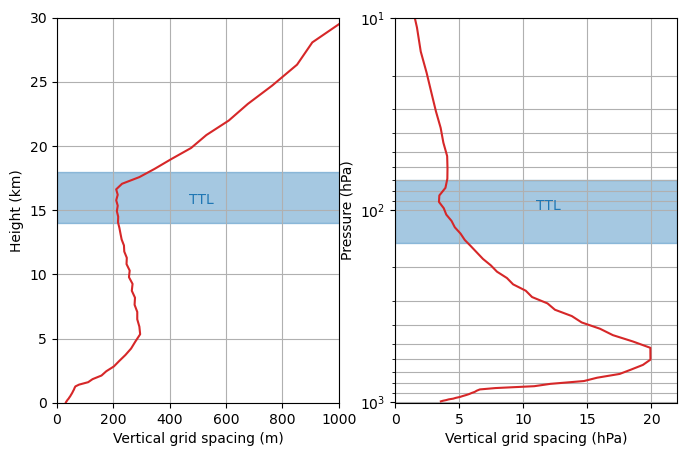

In [32]:
fig, [ax,axp] = plt.subplots(1,2,figsize=(8,5))
ax.plot(dz[::2], z_mid[::2]/1000, color='C3')
ax.fill_between([0,1500],14,18, color='C0', alpha=0.4)
ax.set_xlim([0,1000])
ax.set_ylim([0,30])
ax.set_xlabel("Vertical grid spacing (m)")
ax.set_ylabel("Height (km)")
ax.annotate("TTL", (470,15.5), xycoords="data", color="C0")
ax.grid(True)

axp.plot(dp[::2], p_mid[::2], color='C3')
axp.fill_between([0,22],70,150, color='C0', alpha=0.4)
axp.set_xlim([0,22])
axp.set_ylim([1013, 10])
axp.set_yscale("log")
axp.set_xlabel("Vertical grid spacing (hPa)")
axp.set_ylabel("Pressure (hPa)")
axp.annotate("TTL", (0.5,0.5), xycoords="axes fraction", color="C0")
axp.grid(True, which="both")
plt.savefig("plots/vertical_grid_spacing_128levs.png", dpi=120, bbox_inches="tight")
plt.show()


### omega

In [33]:
omega = sc.OMEGA.isel(time=0).mean(dim=["ncol"])
omega.shape

(128,)

In [34]:
w = omega2w(sc).isel(time=0).mean(dim=["ncol"])
w.shape

(128,)

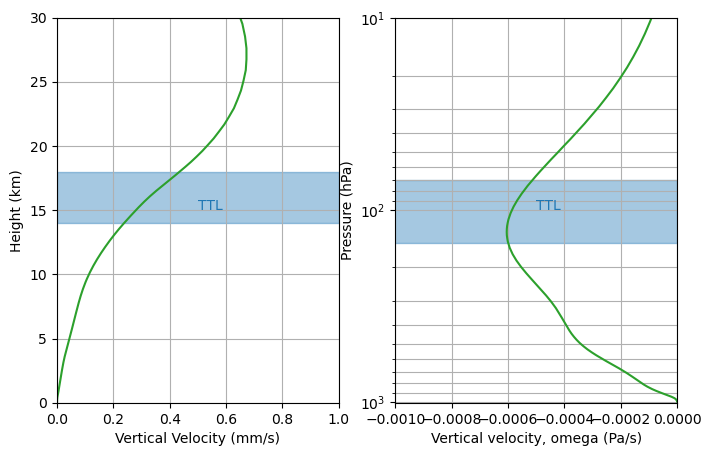

In [35]:
fig, [ax,axp] = plt.subplots(1,2,figsize=(8,5))
ax.plot(w*1000, z/1000, color='C2')
ax.fill_between([0,1],14,18, color='C0', alpha=0.4)
ax.set_xlim([0,1])
ax.set_ylim([0,30])
ax.set_xlabel("Vertical Velocity (mm/s)")
ax.set_ylabel("Height (km)")
ax.annotate("TTL", (0.5,0.5), xycoords="axes fraction", color="C0")
ax.grid(True)

axp.plot(omega, omega.lev, color='C2')
axp.fill_between([-1,0],70,150, color='C0', alpha=0.4)
axp.set_xlim([-0.001,0])
axp.set_ylim([1013,10])
axp.set_yscale("log")
axp.set_xlabel("Vertical velocity, omega (Pa/s)")
axp.set_ylabel("Pressure (hPa)")
axp.annotate("TTL", (0.5,0.5), xycoords="axes fraction", color="C0")
axp.grid(True, which="both")

plt.savefig("plots/vertical_velocity_128levs_pz.png", dpi=120, bbox_inches="tight")
plt.show()

### aerosol profiles

In [43]:
aero = xr.open_dataset("../run_scripts/Cheyenne/cami_mam3_Linoz_ne30np4_SCREAM_L128_c160214.nc")
aero = aero.O3.isel(time=0).isel(ncol=0) # O3, H2SO4, H2O2
aero

<xarray.DataArray 'O3' (lev: 128)>
[128 values with dtype=float64]
Coordinates:
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
    time     object 0004-01-01 00:00:00
Attributes:
    mdims:      
    units:      kg/kg
    long_name:  O3

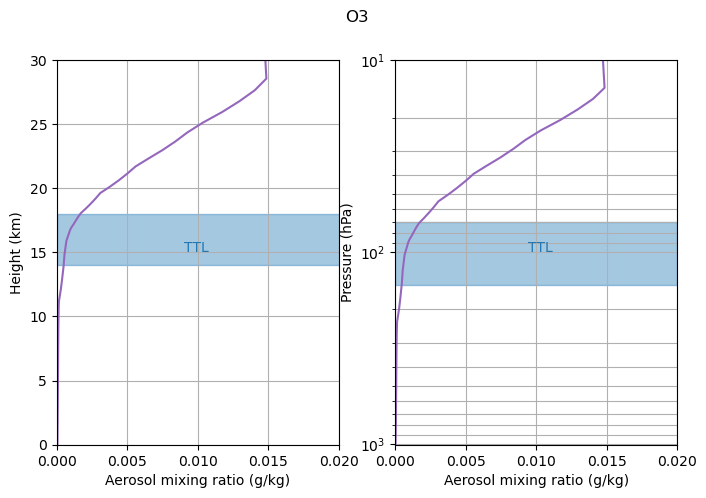

In [45]:
# aerosol profile
# aerosol optical depth
# plot
xmax = 0.02 # 1e-6, 1e-9, 0.02
fig, [ax,axp] = plt.subplots(1,2,figsize=(8,5))
ax.plot(aero*1000, z/1000, color='C4')
ax.fill_between([0,1],14,18, color='C0', alpha=0.4)
ax.set_xlim([0,xmax])
ax.set_ylim([0,30])
ax.set_xlabel("Aerosol mixing ratio (g/kg)")
ax.set_ylabel("Height (km)")
ax.annotate("TTL", (0.45,0.5), xycoords="axes fraction", color="C0")
ax.grid(True)

axp.plot(aero*1000, p, color='C4')
axp.fill_between([0,0.02],70,150, color='C0', alpha=0.4)
axp.set_xlim([0,xmax])
axp.set_ylim([1013,10])
axp.set_yscale("log")
axp.set_xlabel("Aerosol mixing ratio (g/kg)")
axp.set_ylabel("Pressure (hPa)")
axp.annotate("TTL", (0.47,0.5), xycoords="axes fraction", color="C0")
axp.grid(True, which="both")
fig.suptitle(aero.attrs["long_name"])
plt.savefig("plots/aerosol_{}_128levs_pz.png".format(aero.attrs["long_name"]), 
            dpi=120, bbox_inches="tight", pad_inches=0.5)
plt.show()